In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Homework Python/Final Project\/data.csv', encoding= 'unicode_escape')

In [ ]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# Data Pre-processing

## Data cleansing

### Cek Tipe Data

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Ada attribute yang tipe datanya kurang sesuai, sehingga dilakukan penanganan untuk menyesuaikan tipe data

In [ ]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


### Cek Missing Value

In [ ]:
round(data.isnull().sum()/data.shape[0]*100,2)

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

 Handling Missing Value pada Description

In [ ]:
data[data['Description'].isnull()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
535322,581199,84581,NaN,-2,2011-12-07 18:26:00,0.0,NaN,United Kingdom
535326,581203,23406,NaN,15,2011-12-07 18:31:00,0.0,NaN,United Kingdom
535332,581209,21620,NaN,6,2011-12-07 18:35:00,0.0,NaN,United Kingdom
536981,581234,72817,NaN,27,2011-12-08 10:33:00,0.0,NaN,United Kingdom


Dari dataframe yang ditampilkan, sekilas dapat terlihat bahwa data yang kosong pada description, cenderung memiliki harga 0. Untuk lebih memastikan dapat melihat UnitPrice pada tiap data NaN pada description

In [ ]:
data[data.Description.isnull()].UnitPrice.value_counts()

0.0    1454
Name: UnitPrice, dtype: int64

Terlihat bahwa semua data yang kosong memiliki nilai 0, oleh karena itu data dihilangkan semua

In [ ]:
data = data[data['Description'].notnull()]

In [ ]:
data.Description.isnull().value_counts()

False    540455
Name: Description, dtype: int64

In [ ]:
round(data.isnull().sum()/data.shape[0]*100,2)

InvoiceNo       0.00
StockCode       0.00
Description     0.00
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.72
Country         0.00
dtype: float64

Handling Missing Value pada CustomerID

In [ ]:
value = {'CustomerID':'Guest'}
data = data.fillna(value = value)
data[data.CustomerID == 'Guest'].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,Guest,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,Guest,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,Guest,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,Guest,United Kingdom
1447,536544,21790,VINTAGE SNAP CARDS,9,2010-12-01 14:32:00,1.66,Guest,United Kingdom


Data NaN pada CustomerID dihandling dengan mengganti nilai kosong dengan 'guest'

In [ ]:
round(data.isnull().sum()/data.shape[0]*100,2)

InvoiceNo      0.0
StockCode      0.0
Description    0.0
Quantity       0.0
InvoiceDate    0.0
UnitPrice      0.0
CustomerID     0.0
Country        0.0
dtype: float64

Handling noisy pada UnitPrice 

In [ ]:
#Menghilangkan yang bernilai 0
data = data[data['UnitPrice']!=0.0]

In [ ]:
(data['UnitPrice']==0.0).value_counts()

False    539394
Name: UnitPrice, dtype: int64

In [ ]:
data.describe()

,Quantity,UnitPrice
count,539394.000000,539394.000000
mean,9.845871,4.632614
std,215.412253,96.984656
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


Nilai minimum pada quantity dan unitprice bernilai negatif, sehingga menimbulkan asumsi adanya noise atau error pada data

In [ ]:
#Menghilangkan Data negatif
data = data[(data['UnitPrice']>0) & (data['Quantity']>0)]

In [ ]:
data.describe()

,Quantity,UnitPrice
count,530104.000000,530104.000000
mean,10.542037,3.907625
std,155.524124,35.915681
min,1.000000,0.001000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,13541.330000


### Cek Duplikasi Data

In [ ]:
#Melihat banyaknya data terduplikasi
print('Banyaknya Duplikasi Data : {}'.format(data.duplicated().sum()))

Banyaknya Duplikasi Data : 5226


In [ ]:
data = data.drop_duplicates()

In [ ]:
jumlahDuplikat = data.duplicated().sum()
print('Banyaknya Duplikasi Data : {}'.format(data.duplicated().sum()))

Banyaknya Duplikasi Data : 0


### Outlier Data

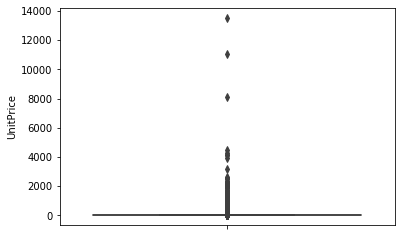

In [ ]:
sns.boxplot(y=data.UnitPrice)

terlihat nilai outlier yang ekstrem, dicoba melihat nilai UnitPrice yang berada diatas 500

In [ ]:
data[data.UnitPrice>500].loc[::,:]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1814,536544,DOT,DOTCOM POSTAGE,1,2010-12-01 14:32:00,569.77,Guest,United Kingdom
3041,536592,DOT,DOTCOM POSTAGE,1,2010-12-01 17:06:00,607.49,Guest,United Kingdom
6165,536876,DOT,DOTCOM POSTAGE,1,2010-12-03 11:36:00,887.52,Guest,United Kingdom
10812,537237,DOT,DOTCOM POSTAGE,1,2010-12-06 09:58:00,863.74,Guest,United Kingdom
11381,537240,DOT,DOTCOM POSTAGE,1,2010-12-06 10:08:00,940.87,Guest,United Kingdom
...,...,...,...,...,...,...,...,...
536834,581219,DOT,DOTCOM POSTAGE,1,2011-12-08 09:28:00,1008.96,Guest,United Kingdom
537254,581238,DOT,DOTCOM POSTAGE,1,2011-12-08 10:53:00,1683.75,Guest,United Kingdom
539368,581439,DOT,DOTCOM POSTAGE,1,2011-12-08 16:30:00,938.59,Guest,United Kingdom
540908,581492,DOT,DOTCOM POSTAGE,1,2011-12-09 10:03:00,933.17,Guest,United Kingdom


Terlihat bahwa stockcode 'DOT' mendominasi data outlier

In [ ]:
data['StockCode'].nunique()

3922

In [ ]:
data[(data.StockCode == 'DOT') | (data.StockCode == 'M') | (data.StockCode == 'AMAZONFEE')].shape

(1024, 8)

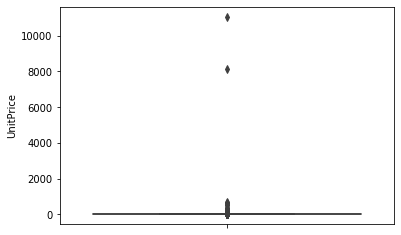

In [ ]:
data = data[(data.StockCode != 'DOT') & (data.StockCode != 'M') & (data.StockCode != 'AMAZONFEE')].copy()
sns.boxplot(y=data.UnitPrice)

In [ ]:
data[data.UnitPrice>500].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
173382,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029,United Kingdom
187584,552980,POST,POSTAGE,1,2011-05-12 14:52:00,523.00,12590,Germany
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.50,15098,United Kingdom
222682,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,2011-06-10 15:33:00,649.50,15098,United Kingdom
236402,557754,POST,POSTAGE,1,2011-06-22 13:12:00,700.00,12432,Norway


In [ ]:
data[data.UnitPrice>200].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
4989,536835,22655,VINTAGE RED KITCHEN CABINET,1,2010-12-02 18:06:00,295.0,13145,United Kingdom
32484,539080,22655,VINTAGE RED KITCHEN CABINET,1,2010-12-16 08:41:00,295.0,16607,United Kingdom
51636,540647,22655,VINTAGE RED KITCHEN CABINET,1,2011-01-10 14:57:00,295.0,17406,United Kingdom
82768,543253,22655,VINTAGE RED KITCHEN CABINET,1,2011-02-04 15:32:00,295.0,14842,United Kingdom
118769,546480,22656,VINTAGE BLUE KITCHEN CABINET,1,2011-03-14 11:38:00,295.0,13452,United Kingdom


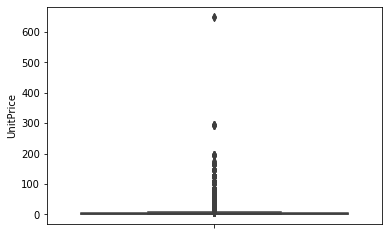

In [ ]:
data = data[(data.StockCode != 'B') & (data.StockCode != 'POST')].copy()
sns.boxplot(y=data.UnitPrice)

In [ ]:
data[data.UnitPrice>200].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
4989,536835,22655,VINTAGE RED KITCHEN CABINET,1,2010-12-02 18:06:00,295.0,13145,United Kingdom
32484,539080,22655,VINTAGE RED KITCHEN CABINET,1,2010-12-16 08:41:00,295.0,16607,United Kingdom
51636,540647,22655,VINTAGE RED KITCHEN CABINET,1,2011-01-10 14:57:00,295.0,17406,United Kingdom
82768,543253,22655,VINTAGE RED KITCHEN CABINET,1,2011-02-04 15:32:00,295.0,14842,United Kingdom
118769,546480,22656,VINTAGE BLUE KITCHEN CABINET,1,2011-03-14 11:38:00,295.0,13452,United Kingdom


In [ ]:
data.describe()

,Quantity,UnitPrice
count,522727.000000,522727.000000
mean,10.639544,3.287967
std,156.566216,4.465096
min,1.000000,0.001000
25%,1.000000,1.250000
50%,4.000000,2.080000
75%,12.000000,4.130000
max,80995.000000,649.500000


In [ ]:
data[data.Quantity>500].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
730,536437,17021,NAMASTE SWAGAT INCENSE,600,2010-12-01 12:12:00,0.24,13694,United Kingdom
3917,536736,22616,PACK OF 12 LONDON TISSUES,600,2010-12-02 12:59:00,0.29,17381,United Kingdom
4850,536809,84950,ASSORTED COLOUR T-LIGHT HOLDER,1824,2010-12-02 16:48:00,0.55,15299,United Kingdom
4945,536830,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,2880,2010-12-02 17:38:00,0.18,16754,United Kingdom
4946,536830,21915,RED HARMONICA IN BOX,1400,2010-12-02 17:38:00,1.06,16754,United Kingdom


In [ ]:
data[data.Quantity>200].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
181,536387,22466,FAIRY TALE COTTAGE NIGHTLIGHT,432,2010-12-01 09:58:00,1.45,16029,United Kingdom
182,536387,21731,RED TOADSTOOL LED NIGHT LIGHT,432,2010-12-01 09:58:00,1.25,16029,United Kingdom
219,536390,20668,DISCO BALL CHRISTMAS DECORATION,288,2010-12-01 10:19:00,0.10,17511,United Kingdom
730,536437,17021,NAMASTE SWAGAT INCENSE,600,2010-12-01 12:12:00,0.24,13694,United Kingdom
870,536477,21137,BLACK RECORD COVER FRAME,480,2010-12-01 12:27:00,3.39,16210,United Kingdom


# Exploratory Data Analysis

In [ ]:
#Membuat attribute baru total transaksi
data['TotalTransaction'] = data['Quantity']*data['UnitPrice']

In [ ]:
#Membuat kolom baru bulan dan tahun
data['Month']= data['InvoiceDate'].apply(lambda x:x.month)
data['Year']= data['InvoiceDate'].apply(lambda x:x.year)

In [ ]:
df= data.sort_values(by=['Year','Month'])

In [ ]:
mmap={1:'Jan11',2:'Feb11',3:'Mar11',4:'Apr11', 5:'May11', 6:'Jun11', 7:'Jul11',8:'Aug11',9:'Sep11',10:'Oct11',11:'Nov11',12:'Dec11'}

In [ ]:
df['MonthName']=df['Month'].map(mmap)

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalTransaction,Month,Year,MonthName
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,12,2010,Dec11
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,12,2010,Dec11
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,12,2010,Dec11
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,12,2010,Dec11
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,12,2010,Dec11


In [ ]:
def month(x):
    Month=x[0]
    Year=x[1]
    
    if Year==2010:
        Month='Dec10'
        return Month
    else:
        return Month

In [ ]:
df['MonthName']=df[['MonthName','Year']].apply(month, axis=1)

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalTransaction,Month,Year,MonthName
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,12,2010,Dec10
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,12,2010,Dec10
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,12,2010,Dec10
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,12,2010,Dec10
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,12,2010,Dec10


## Total Transaksi Per Bulan

In [ ]:
monthly= df.groupby(['Year','Month','MonthName']).sum()

In [ ]:
monthly

Quantity   UnitPrice  TotalTransaction
Year Month MonthName                                        
2010 12    Dec10        357543  156770.550        776332.500
2011 1     Jan11        386746  113442.120        670654.460
     2     Feb11        282635   95055.310        508081.540
     3     Mar11        376198  123076.090        690591.840
     4     Apr11        307666   95916.071        515914.661
     5     May11        394668  124065.150        740487.330
     6     Jun11        388141  120427.720        738233.990
     7     Jul11        399303  116403.961        688802.671
     8     Aug11        420709  107929.050        724708.160
     9     Sep11        568723  150796.102       1029275.382
     10    Oct11        619615  180916.700       1104093.970
     11    Nov11        746977  254339.510       1453295.980
     12    Dec11        312653   79570.830        614714.250

In [ ]:
monthly.reset_index(inplace=True)

In [ ]:
monthly

,Year,Month,MonthName,Quantity,UnitPrice,TotalTransaction
0,2010,12,Dec10,357543,156770.550,776332.500
1,2011,1,Jan11,386746,113442.120,670654.460
2,2011,2,Feb11,282635,95055.310,508081.540
3,2011,3,Mar11,376198,123076.090,690591.840
4,2011,4,Apr11,307666,95916.071,515914.661
5,2011,5,May11,394668,124065.150,740487.330
6,2011,6,Jun11,388141,120427.720,738233.990
7,2011,7,Jul11,399303,116403.961,688802.671
8,2011,8,Aug11,420709,107929.050,724708.160
9,2011,9,Sep11,568723,150796.102,1029275.382


Text(0, 0.5, 'Total Transaksi')

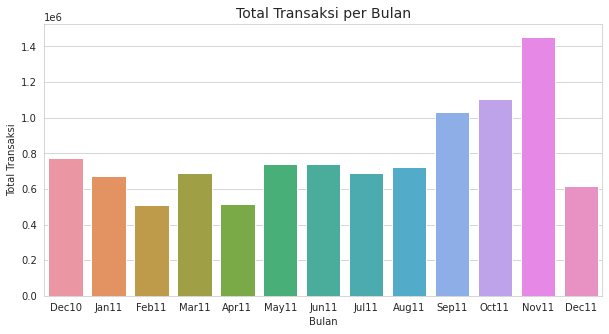

In [ ]:
plt.figure(figsize=(10,5))
sns.set_style('whitegrid')
sns.barplot(x='MonthName', y='TotalTransaction', data=monthly)
plt.title('Total Transaksi per Bulan', fontsize=14)
plt.xlabel('Bulan')
plt.ylabel('Total Transaksi')

Transaksi tertinggi terjadi pada tahun Bulan November 2011

In [ ]:
Nov11 = df[(df['Month']==11) & (df['Year']==2011)]

In [ ]:
Nov11.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81752 entries, 431673 to 516368
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   InvoiceNo         81752 non-null  object        
 1   StockCode         81752 non-null  object        
 2   Description       81752 non-null  object        
 3   Quantity          81752 non-null  int64         
 4   InvoiceDate       81752 non-null  datetime64[ns]
 5   UnitPrice         81752 non-null  float64       
 6   CustomerID        81752 non-null  object        
 7   Country           81752 non-null  object        
 8   TotalTransaction  81752 non-null  float64       
 9   Month             81752 non-null  int64         
 10  Year              81752 non-null  int64         
 11  MonthName         81752 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(6)
memory usage: 8.1+ MB


In [ ]:
Nov11= Nov11.groupby(['StockCode','Description']).sum().sort_values(by='TotalTransaction', ascending = False)

In [ ]:
Nov11

,,Quantity,UnitPrice,TotalTransaction,Month,Year
StockCode,Description,,,,,
23084,RABBIT NIGHT LIGHT,14913,1115.95,34478.40,5533,1011533
22086,PAPER CHAIN KIT 50'S CHRISTMAS,7898,1297.94,28955.54,4422,808422
22197,POPCORN HOLDER,12452,251.97,14188.80,2783,508783
85123A,WHITE HANGING HEART T-LIGHT HOLDER,4908,811.86,14130.80,2827,516827
22423,REGENCY CAKESTAND 3 TIER,1052,3002.91,13774.08,2244,410244
...,...,...,...,...,...,...
71496A,A4 WALL TIDY BLUE OFFICE,1,0.53,0.53,11,2011
71496B,A4 WALL TIDY RED FLOWERS,1,0.53,0.53,11,2011
79063C,"RETRO PILL BOX KEY CHAIN,THE KING",2,0.38,0.38,22,4022


10 Item Penjualan Tertinggi di 2011

In [ ]:
Nov11[['TotalTransaction']].head(10)

,,TotalTransaction
StockCode,Description,
23084,RABBIT NIGHT LIGHT,34478.40
22086,PAPER CHAIN KIT 50'S CHRISTMAS,28955.54
22197,POPCORN HOLDER,14188.80
85123A,WHITE HANGING HEART T-LIGHT HOLDER,14130.80
22423,REGENCY CAKESTAND 3 TIER,13774.08
22910,PAPER CHAIN KIT VINTAGE CHRISTMAS,12929.74
23355,HOT WATER BOTTLE KEEP CALM,11760.07
85099B,JUMBO BAG RED RETROSPOT,11639.29
79321,CHILLI LIGHTS,11485.77


In [ ]:
pivot=df.pivot_table(index=['StockCode','Description'], values='TotalTransaction', columns='MonthName', aggfunc='sum').sort_values(by='Nov11', ascending=False)

In [ ]:
pivot.head(10)

,MonthName,Apr11,Aug11,Dec10,Dec11,Feb11,Jan11,Jul11,Jun11,Mar11,May11,Nov11,Oct11,Sep11
StockCode,Description,,,,,,,,,,,,,
23084,RABBIT NIGHT LIGHT,NaN,3533.57,NaN,9628.46,NaN,NaN,668.59,3326.87,NaN,2277.49,34478.40,12256.87,699.78
22086,PAPER CHAIN KIT 50'S CHRISTMAS,41.08,1329.04,9208.10,6867.76,24.95,143.32,1077.93,910.88,232.01,65.19,28955.54,10022.54,5997.25
22197,POPCORN HOLDER,NaN,4061.35,NaN,5423.80,NaN,NaN,1509.40,800.44,NaN,NaN,14188.80,4810.55,3494.33
85123A,WHITE HANGING HEART T-LIGHT HOLDER,10017.79,5620.57,10435.36,2047.90,5140.11,15205.51,8495.26,4680.81,5597.90,11216.42,14130.80,4750.15,6945.66
22423,REGENCY CAKESTAND 3 TIER,14812.95,10521.30,27694.76,5994.12,11009.49,12800.60,13936.11,9732.64,18359.25,12645.97,13774.08,13255.74,9619.53
22910,PAPER CHAIN KIT VINTAGE CHRISTMAS,102.00,1224.17,5010.52,2760.61,35.40,89.91,1201.93,24.33,102.00,36.75,12929.74,4833.97,4492.51
23355,HOT WATER BOTTLE KEEP CALM,NaN,593.52,NaN,3974.68,NaN,NaN,NaN,NaN,NaN,NaN,11760.07,6135.99,6254.54
85099B,JUMBO BAG RED RETROSPOT,4878.08,10622.56,4019.15,2226.90,5617.24,5047.65,6253.87,7247.98,10118.38,7122.73,11639.29,10485.81,8880.17
79321,CHILLI LIGHTS,357.50,2260.33,7506.44,2639.74,3616.25,5891.23,4289.24,2310.29,3087.30,2296.75,11485.77,4678.13,3677.39


## Item terlaris

In [ ]:
qty=df.pivot_table(index=['StockCode','Description'], values='Quantity', aggfunc='sum').sort_values(by='Quantity', ascending=False)

In [ ]:
qty.reset_index(inplace=True)

In [ ]:
qty

,StockCode,Description,Quantity
0,23843,"PAPER CRAFT , LITTLE BIRDIE",80995
1,23166,MEDIUM CERAMIC TOP STORAGE JAR,78033
2,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,54951
3,85099B,JUMBO BAG RED RETROSPOT,48371
4,85123A,WHITE HANGING HEART T-LIGHT HOLDER,37580
...,...,...,...
4151,35609A,PINK FEATHER CHRISTMAS DECORATION,1
4152,20703,BLUE PADDED SOFT MOBILE,1
4153,21120,*Boombox Ipod Classic,1
4154,84510e,SET OF 4 GREEN CAROUSEL COASTERS,1


Text(0, 0.5, 'Item')

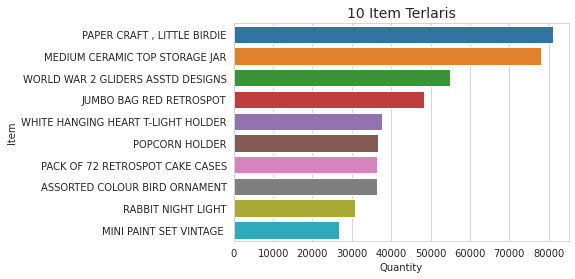

In [ ]:
sns.barplot(y='Description', x='Quantity', data=qty.head(10))
plt.title('10 Item Terlaris', fontsize=14)
plt.ylabel('Item')

### Item Paling Tidak Laris

In [ ]:
qty1=qty[qty['Quantity']>0]

Text(0, 0.5, 'Item')

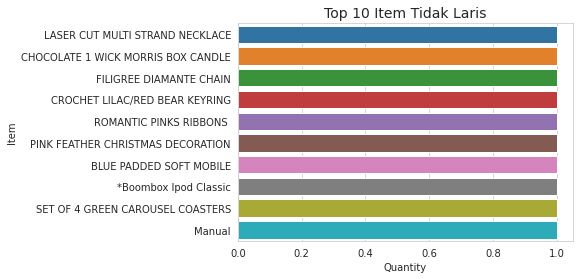

In [ ]:
sns.barplot(y='Description', x='Quantity', data=qty1.tail(10))
plt.title('Top 10 Item Tidak Laris', fontsize=14)
plt.ylabel('Item')

### Customer aktif dan tidak aktif

In [ ]:
cust=df.groupby('CustomerID').max().sort_values(by='InvoiceDate', ascending=False)

In [ ]:
cust.loc[cust['InvoiceDate'] < '2011-06-09', 'Churn']='Yes'
cust.loc[cust['InvoiceDate'] >= '2011-06-09', 'Churn']='No'

In [ ]:
cust[cust['Churn']=='Yes']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,TotalTransaction,Month,Year,MonthName,Churn
CustomerID,,,,,,,,,,,,
13466.0,556105,84946,WRAP VINTAGE PETALS DESIGN,50,2011-06-08 16:39:00,12.75,United Kingdom,35.40,6,2011,Jun11,Yes
16832.0,556098,47590A,ROSE COTTAGE KEEPSAKE BOX,12,2011-06-08 15:36:00,16.95,United Kingdom,62.50,6,2011,May11,Yes
15609.0,556048,84849A,WHITE BROCANTE SOAP DISH,24,2011-06-08 13:00:00,16.95,United Kingdom,30.00,6,2011,Jun11,Yes
14622.0,556040,85099C,WOODEN PICTURE FRAME WHITE FINISH,24,2011-06-08 12:42:00,7.95,United Kingdom,23.60,6,2011,Jun11,Yes
17409.0,555945,85014B,WHITE LOVEBIRD LANTERN,12,2011-06-08 10:36:00,14.95,United Kingdom,119.60,6,2011,Jun11,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...
16583.0,536420,22969,WOODEN BOX OF DOMINOES,12,2010-12-01 12:03:00,4.95,United Kingdom,20.40,12,2010,Dec10,Yes
17908.0,536409,90210B,WHITE SKULL HOT WATER BOTTLE,28,2010-12-01 11:45:00,7.95,United Kingdom,19.05,12,2010,Dec10,Yes
12791.0,536403,22867,HAND WARMER BIRD DESIGN,96,2010-12-01 11:27:00,1.85,Netherlands,177.60,12,2010,Dec10,Yes


In [ ]:
churn=cust.reset_index().groupby('Churn').count()

In [ ]:
churn.head()

,CustomerID,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,TotalTransaction,Month,Year,MonthName
Churn,,,,,,,,,,,,
No,3489,3489,3489,3489,3489,3489,3489,3489,3489,3489,3489,3489
Yes,847,847,847,847,847,847,847,847,847,847,847,847


([<matplotlib.patches.Wedge at 0x7fc163b8f090>,
 [Text(-0.8992858862833162, 0.6334705160712933, 'Aktif'),
  Text(0.8992858566284203, -0.6334705581699029, 'Tidak Aktif')],
 [Text(-0.49051957433635424, 0.34552937240252357, '80%'),
  Text(0.4905195581609565, -0.34552939536540156, '20%')])

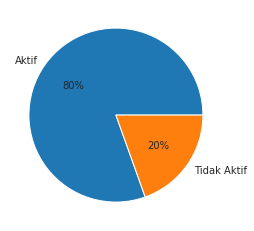

In [ ]:
plt.pie(churn['CustomerID'], labels=['Aktif', 'Tidak Aktif'], autopct='%1.0f%%')

### Negara penjualan terbanyak

In [ ]:
df['TotalQuantity'] = df['Quantity']*df['UnitPrice']

           Country  TotalQuantity
36  United Kingdom   8.726835e+06
24     Netherlands   2.838893e+05
10            EIRE   2.760909e+05
14         Germany   2.053811e+05
13          France   1.846790e+05
0        Australia   1.381038e+05
31           Spain   5.570656e+04
AxesSubplot(0.125,0.125;0.775x0.755)


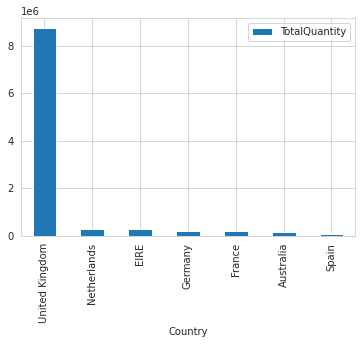

In [ ]:
data_temp = df.groupby(['Country'])['TotalQuantity'].sum().reset_index().sort_values('TotalQuantity',ascending=False).head(7)
print(data_temp)
print(data_temp.plot(x='Country', y='TotalQuantity',kind='bar'))

In [ ]:
df[df['TotalQuantity']==df['TotalQuantity'].max()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalTransaction,Month,Year,MonthName,TotalQuantity
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom,168469.6,12,2011,Dec11,168469.6


Check data UK lebih spesifik

In [ ]:
rfm_data = df[df['Country']=='United Kingdom']

In [ ]:
rfm_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 478950 entries, 0 to 541893
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   InvoiceNo         478950 non-null  object        
 1   StockCode         478950 non-null  object        
 2   Description       478950 non-null  object        
 3   Quantity          478950 non-null  int64         
 4   InvoiceDate       478950 non-null  datetime64[ns]
 5   UnitPrice         478950 non-null  float64       
 6   CustomerID        478950 non-null  object        
 7   Country           478950 non-null  object        
 8   TotalTransaction  478950 non-null  float64       
 9   Month             478950 non-null  int64         
 10  Year              478950 non-null  int64         
 11  MonthName         478950 non-null  object        
 12  TotalQuantity     478950 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(6)
memor

In [ ]:
rfm_data.describe()

,Quantity,UnitPrice,TotalTransaction,Month,Year,TotalQuantity
count,478950.000000,478950.000000,478950.000000,478950.000000,478950.000000,478950.000000
mean,9.686172,3.306960,18.220764,7.574726,2010.919303,18.220764
std,162.891190,4.463201,280.982663,3.519228,0.272370,280.982663
min,1.000000,0.001000,0.001000,1.000000,2010.000000,0.001000
25%,1.000000,1.250000,3.400000,5.000000,2011.000000,3.400000
50%,3.000000,2.100000,8.500000,8.000000,2011.000000,8.500000
75%,10.000000,4.130000,17.000000,11.000000,2011.000000,17.000000
max,80995.000000,649.500000,168469.600000,12.000000,2011.000000,168469.600000


In [ ]:
#filtering necessary columns 
rfm_data=rfm_data[['CustomerID','InvoiceDate','InvoiceNo','Quantity','UnitPrice']]
rfm_data['TotalPrice'] = rfm_data['Quantity'] * rfm_data['UnitPrice']
rfm_data['InvoiceDate'].min(),rfm_data['InvoiceDate'].max()

(Timestamp('2010-12-01 08:26:00'), Timestamp('2011-12-09 12:49:00'))

In [ ]:
PRESENT = dt.datetime(2011,12,10)
rfm_data['InvoiceDate'] = pd.to_datetime(rfm_data['InvoiceDate'])

rfm_data.head()

,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice,TotalPrice
0,17850,2010-12-01 08:26:00,536365,6,2.55,15.30
1,17850,2010-12-01 08:26:00,536365,6,3.39,20.34
2,17850,2010-12-01 08:26:00,536365,8,2.75,22.00
3,17850,2010-12-01 08:26:00,536365,6,3.39,20.34
4,17850,2010-12-01 08:26:00,536365,6,3.39,20.34


# Recency, Frequency and Monetary



1.   Recency dihitung jumlah hari antara tanggal sekarang dan tanggal pembelian terakhir setiap pelanggan
2.   Frekuensi dihitung dengan jumlah pesanan untuk setiap pelanggan
3.   Monetary dihitung jumlah harga pembelian untuk setiap pelanggan



In [ ]:
rfm= rfm_data.groupby('CustomerID').agg({'InvoiceDate': lambda date: (PRESENT - date.max()).days,
                                        'InvoiceNo': lambda num: len(num),
                                        'TotalPrice': lambda price: price.sum()})

In [ ]:
rfm.columns

Index(['InvoiceDate', 'InvoiceNo', 'TotalPrice'], dtype='object')

In [ ]:
rfm.columns=['Recency','Frequency','Monetary_Value']

In [ ]:
rfm.head()

,Recency,Frequency,Monetary_Value
CustomerID,,,
12346.0,325,1,77183.60
12747.0,2,103,4196.01
12748.0,0,4397,31650.78
12749.0,3,199,4090.88
12820.0,3,59,942.34


In [ ]:
df[df['CustomerID'] == 12346.0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalTransaction,Month,Year,MonthName,TotalQuantity
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,77183.6,1,2011,Jan11,77183.6


In [ ]:
quantiles = rfm.quantile(q=[0.25,0.50,0.75])
quantiles = quantiles.to_dict()

In [ ]:
segmented_rfm = rfm.copy()

In [ ]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [ ]:
segmented_rfm['R_quartile'] = segmented_rfm['Recency'].apply(RScore, args=('Recency',quantiles))
segmented_rfm['F_quartile'] = segmented_rfm['Frequency'].apply(FMScore, args=('Frequency',quantiles))
segmented_rfm['M_quartile'] = segmented_rfm['Monetary_Value'].apply(FMScore, args=('Monetary_Value',quantiles))
segmented_rfm.head()

,Recency,Frequency,Monetary_Value,R_quartile,F_quartile,M_quartile
CustomerID,,,,,,
12346.0,325,1,77183.60,4,4,1
12747.0,2,103,4196.01,1,1,1
12748.0,0,4397,31650.78,1,1,1
12749.0,3,199,4090.88,1,1,1
12820.0,3,59,942.34,1,2,2


Recency score terbaik = 1: Pembelian sangat baru.  Frequency score terbaik = 1: Quanitas pembelian terbanyak. Monetary score terbaik = 1: Total Pengeluaran terbanyak.

In [ ]:
segmented_rfm['RFM_Segment'] = segmented_rfm.R_quartile.map(str)+segmented_rfm.F_quartile.map(str)+segmented_rfm.M_quartile.map(str)
segmented_rfm.head()

,Recency,Frequency,Monetary_Value,R_quartile,F_quartile,M_quartile,RFM_Segment
CustomerID,,,,,,,
12346.0,325,1,77183.60,4,4,1,441
12747.0,2,103,4196.01,1,1,1,111
12748.0,0,4397,31650.78,1,1,1,111
12749.0,3,199,4090.88,1,1,1,111
12820.0,3,59,942.34,1,2,2,122


In [ ]:
segmented_rfm['RFM_Score'] = segmented_rfm[['R_quartile','F_quartile','M_quartile']].sum(axis=1)
segmented_rfm.head()
segmented_rfm.to_excel('Segmented_RFM.xls')

In [ ]:
print("Pelanggan Terbaik: ",len(segmented_rfm[segmented_rfm['RFM_Segment']=='111']))
print("Transaksi Besar: ",len(segmented_rfm[segmented_rfm['M_quartile']==1]))
print('Pelanggan Hampir Hilang: ', len(segmented_rfm[segmented_rfm['RFM_Segment']=='134']))
print('Pelanggan yang Hilang: ',len(segmented_rfm[segmented_rfm['RFM_Segment']=='444']))

Pelanggan Terbaik:  408
Transaksi Besar:  980
Pelanggan Hampir Hilang:  22
Pelanggan yang Hilang:  341


Strategi Pemasaran


*   Pelanggan Terbaik : tidak ada insentif harga, produk baru, dan program loyalitas
*   Transaksi Besar : Pemasaran produk yang paling mahal
*   Pelanggan Hampir Hilang : Insentif harga yang agresif
*   Pelanggan Hilang : Dibiarkan saja :)



In [ ]:
segmented_rfm['RFM_Score'].unique()

array([ 9,  3,  5, 12,  7,  8,  6, 10, 11,  4])

In [ ]:
segmented_rfm.groupby('RFM_Score').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary_Value': ['mean', 'count'] }).round(1)

Recency Frequency Monetary_Value      
             mean      mean           mean count
RFM_Score                                       
3             6.5     678.2        11793.7   408
4            20.1     181.9         3432.9   348
5            32.5     111.0         1915.2   387
6            46.9      77.7         1785.5   375
7            59.9      54.6          904.7   414
8            79.2      38.7          721.6   385
9            97.9      28.2          830.8   427
10          151.5      20.5          354.8   470
11          175.3      13.6          231.6   363
12          258.7       8.0          151.4   341

Clustering K-Means akan bekerja optimal dalam kondisi


1.   Distribusi data tidak condong (skew)
2.   Data distandarisasi (skala 0-1)



In [ ]:
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column])
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

Recency's: Skew: 1.2432451112675078, : SkewtestResult(statistic=25.259407086248782, pvalue=8.927386879676582e-141)
Frequency's: Skew: 61.607232556839975, : SkewtestResult(statistic=105.11203112492444, pvalue=0.0)
Monetary_Value's: Skew: 54.87734323437105, : SkewtestResult(statistic=102.68713908593398, pvalue=0.0)


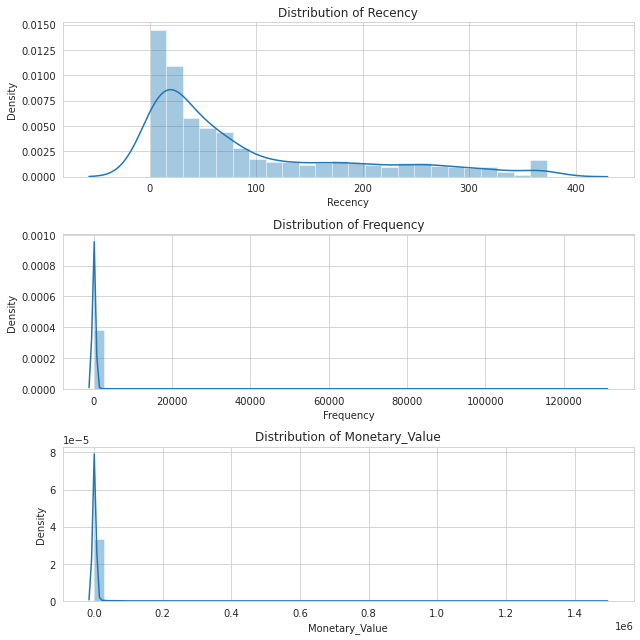

In [ ]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(rfm,'Recency')

plt.subplot(3, 1, 2)
check_skew(rfm,'Frequency')

plt.subplot(3, 1, 3)
check_skew(rfm,'Monetary_Value')

plt.tight_layout()
plt.savefig('before_transform.png', format='png', dpi=1000)

Dilakukan transformasi LOG pada data agar menghilangkan kecondongan distribusi data

In [ ]:
rfm_log = rfm.copy()

Recency's: Skew: -0.46415200754715585, : SkewtestResult(statistic=-11.32463372368064, pvalue=9.909220080189249e-30)
Frequency's: Skew: 0.041032138386072226, : SkewtestResult(statistic=1.0500885165864537, pvalue=0.2936774178782543)
Monetary_Value's: Skew: 0.4183270572117415, : SkewtestResult(statistic=10.291839024502343, pvalue=7.669731792929653e-25)


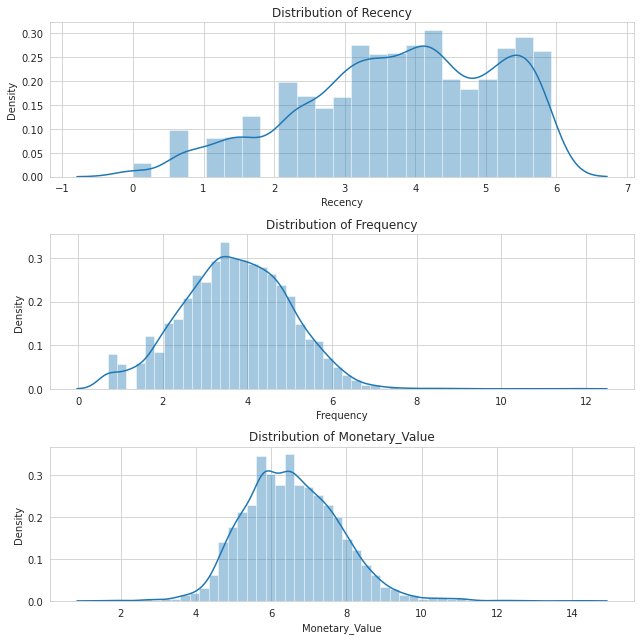

In [ ]:
rfm_log = np.log(rfm_log+1)

plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(rfm_log,'Recency')

plt.subplot(3, 1, 2)
check_skew(rfm_log,'Frequency')

plt.subplot(3, 1, 3)
check_skew(rfm_log,'Monetary_Value')

plt.tight_layout()

In [ ]:
rfm.describe()

,Recency,Frequency,Monetary_Value
count,3918.000000,3918.000000,3.918000e+03
mean,91.870087,122.243492,2.227370e+03
std,99.748296,2086.960074,2.479209e+04
min,0.000000,1.000000,3.750000e+00
25%,17.000000,17.000000,2.980275e+02
50%,50.000000,40.500000,6.449750e+02
75%,143.000000,98.000000,1.567637e+03
max,373.000000,130033.000000,1.482340e+06


In [ ]:
windsoriser = Winsorizer(capping_method='gaussian', 
                         tail='both',
                         fold=2,
                         variables=[ 'Recency', 'Frequency', 'Monetary_Value'])

windsoriser.fit(rfm_log)

Winsorizer(capping_method='gaussian', fold=2, missing_values='raise',
           tail='both', variables=['Recency', 'Frequency', 'Monetary_Value'])

In [ ]:
rfm_log = windsoriser.transform(rfm_log)

In [ ]:
rfm_log

,Recency,Frequency,Monetary_Value
CustomerID,,,
12346.0,5.786897,1.197419,9.040319
12747.0,1.098612,4.644391,8.342128
12748.0,1.029061,6.233999,9.040319
12749.0,1.386294,5.298317,8.316760
12820.0,1.386294,4.094345,6.849427
...,...,...,...
18281.0,5.198497,2.079442,4.404522
18282.0,2.079442,2.564949,5.187665
18283.0,1.386294,6.233999,7.620989


In [ ]:
scaler = MinMaxScaler()

scaler.fit(rfm_log)

RFM_Table_scaled = scaler.transform(rfm_log)

In [ ]:
RFM_Table_scaled = pd.DataFrame(RFM_Table_scaled, columns=rfm_log.columns)

In [ ]:
RFM_Table_scaled

,Recency,Frequency,Monetary_Value
0,0.971940,0.000000,1.000000
1,0.014208,0.684387,0.860347
2,0.000000,1.000000,1.000000
3,0.072976,0.814223,0.855273
4,0.072976,0.575177,0.561774
...,...,...,...
3913,0.851741,0.175123,0.072741
3914,0.214574,0.271520,0.229386
3915,0.072976,1.000000,0.716103
3916,0.558127,0.608600,0.695220


In [ ]:
RFM_Table_scaled.to_excel('RFM.xls')

# K-Means Clustering

In [ ]:
from scipy.spatial.distance import cdist
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(RFM_Table_scaled) 
    kmeanModel.fit(RFM_Table_scaled)     
      
    distortions.append(sum(np.min(cdist(RFM_Table_scaled, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / RFM_Table_scaled.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(RFM_Table_scaled, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / RFM_Table_scaled.shape[0] 
    mapping2[k] = kmeanModel.inertia_

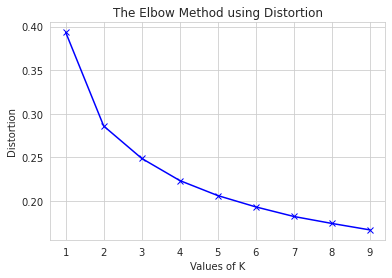

In [ ]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()

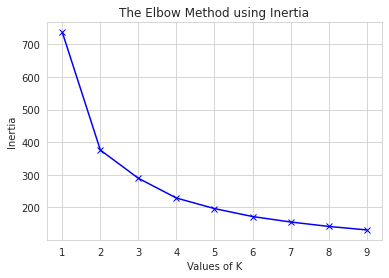

In [ ]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

In [ ]:
def kmeans(normalised_df_rfm, clusters_number, original_df_rfm):
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_rfm)

    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
inertia = []
for i in range(1,13):
    model = KMeans(n_clusters=i, random_state=42)
    model.fit(segmented_rfm[['Frequency','Monetary_Value']])
    inertia.append(model.inertia_)
inertia = pd.DataFrame({'Inertia' : inertia}, index=[i for i in range(1,13)])
inertia

,Inertia
1,2.424636e+12
2,2.164631e+11
3,8.948087e+10
4,2.999411e+10
5,1.876509e+10
6,1.291065e+10
7,8.831247e+09
8,5.693083e+09
9,4.412186e+09
10,3.210741e+09


Text(0.5, 0, 'K Number')

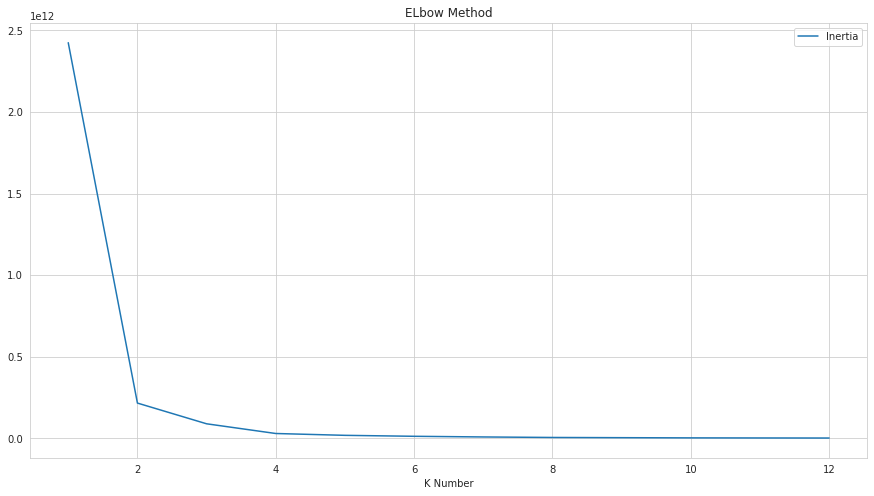

In [ ]:
inertia.plot(kind='line', figsize=(15,8))
plt.title('ELbow Method')
plt.xlabel('K Number')

## Modeling K-Means (Frequency-Monetary)

a. Modeling KMeans n=4

In [ ]:
modelKM = KMeans(n_clusters=4, max_iter=10000, random_state=42)
modelKM.fit(RFM_Table_scaled[['Frequency','Monetary_Value']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=10000,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [ ]:
RFM_Table_scaled['Cluster'] = modelKM.predict(RFM_Table_scaled[['Frequency','Monetary_Value']])

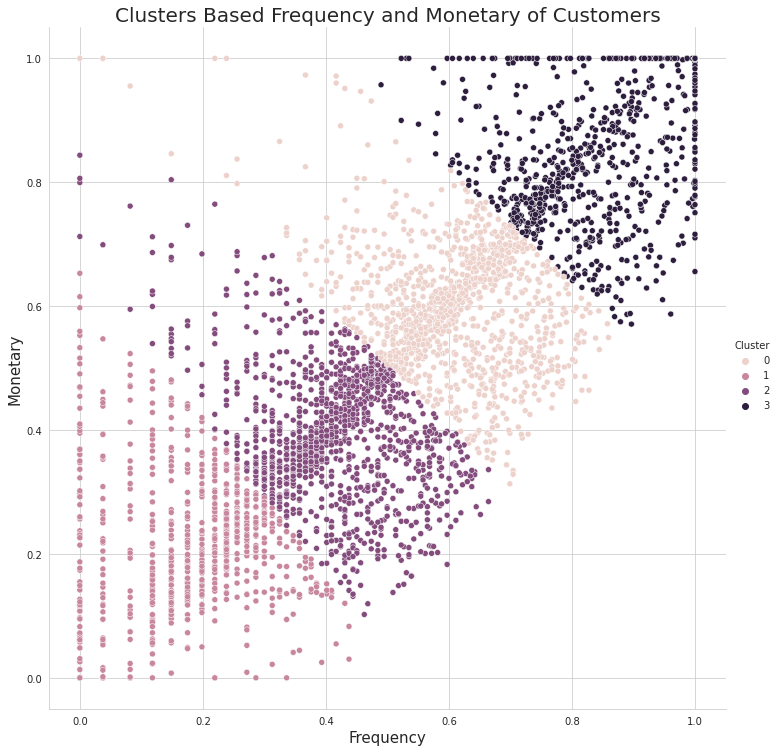

In [ ]:
sns.relplot(x='Frequency',y='Monetary_Value',data=RFM_Table_scaled, hue='Cluster', aspect=1, height=10)
plt.title('Clusters Based Frequency and Monetary of Customers', fontsize= 20)
plt.ylabel('Monetary', fontsize=15)
plt.xlabel('Frequency', fontsize=15)
plt.show()